In [1]:
import numpy as np
import pandas as pd
from datetime import date , datetime

from astropy.time import Time  # for BCE Math
#1400-Dec-31 to 1401-Jan-01 is 1 day;   
#-1400-Dec-31 to -1401-Jan-01 is 2 years .  
import re

%matplotlib inline
import matplotlib.pyplot as plt 

In [2]:
def get_moon_phase_df(fn) :
    df = pd.read_csv(fn)
    #df['Year'] = [  int(re.match("(.\d+)", bstr).groups()[0]) for bstr in [
    #    d.split("-")[0] for d in df.UTC_Date
    #]]
    #df['Month'] = [ int(d.split("-")[1]) for d in df.UTC_Date]
    #df['Day'] = [ int(d.split("-")[2]) for d in df.UTC_Date]
    
    df.UTC_Date = [ Time(d, format="fits").fits for d in df.UTC_Date]
    
    #dts = [date(e.Year, e.Month, e.Day) for e in [  moon_df.iloc[idx] for idx in moon_df.index  ]]
    if False:
        dts = []
        for idx in df.index :
            for e in  [ df.iloc[idx] ]:
                ans = None
                try: 
                    ans = date(e.Year, e.Month, e.Day)
                except:
                    ans = date (e.Year, e.Month, 28)  # xxhack as bc dates have 29/feb for non leap years
                dts.append(ans)

        min_dt = pd.Series(dts).min()
        days = [  (d-min_dt).days for d in dts]
        df['days'] = days
        days    

    return df

def get_moon_eclipse_df(fn) :
    df = pd.read_csv(fn)
    #df['UTC_Date1'] = df.UTC_Date
    #df['UTC_Date'] = [ inc_year(d) for d in df.UTC_Date1]
    
    #df['Year'] = [  int(re.match("(.\d+)", bstr).groups()[0])  for bstr in [d.split("-")[0] for d in df.UTC_Date]]
    #df['Month'] = [ int(d.split("-")[1]) for d in df.UTC_Date]
    #df['Day'] = [ int(d.split("-")[2]) for d in df.UTC_Date]
    
    df.UTC_Date = [ Time(d, format="fits").fits for d in df.UTC_Date]
    
    #df['Year'] = [ d.split("-")[0] for d in df.UTC_Date]
    #df['Month'] = [ d.split("-")[1] for d in df.UTC_Date]
    #df['Day'] = [ d.split("-")[2] for d in df.UTC_Date]
    return df


def join_moon_phase_eclipse_df ( moon_df, ec_df):
    def ecl_tag(df, idx):
        try :
            ans = df.loc[idx, 'EclType']
            return ans
        except:
            return '-'
        
        
    df1 = moon_df.set_index('UTC_Date')
    df1 = df1[df1.RiseTransitSet == 'r']
    #df1 = df1.drop(['Tag','RiseTransitSet', 'LocalTime', 'Year', 'Month', 'Day' ,'UTC_Time'], axis=1)
    df1 = df1.drop(['Tag','RiseTransitSet', 'LocalTime', 'UTC_Time'], axis=1)
    df2 = ec_df.set_index('UTC_Date')
       
    #date MoonRise
    #num  Az
    #num  Phase
    #str  Paksha      Shukla,Krishna
    #num  RA
    #num  Dec
    #num  days
    #num  Fullmoon    1,0
    #num  Newmoon     1,0
    #num  Eclipse     1,0.5,0.1,0  => VisibleFull, VisiblePartial, NotVisible, NoEclipse


    df1['EclType'] = [ ecl_tag(df2, idx) for idx in df1.index]
    df1 = df1.reset_index()
    return df1

def normalize_df (df): 
    #MoonRise = [ re.match('.(.*)',d).groups()[0] for d in df.UTC_Date ]
    MoonRise = pd.Series([ Time(d, format="fits") for d in df.UTC_Date])
    min_date = MoonRise.min()
    max_date = MoonRise.max()    
    days = max_date - MoonRise
    days = pd.Series([ d.value for d in days])
    
    MoonRise = [ re.sub( "T.*", "", d.fits) for d in MoonRise ]
    Az = df.Azimuth
    Phase = df.Illumination
    FullMoon = [ 1 if p >= 99.5 else 0 for p in Phase]
    NewMoon  = [ 1 if p <= 0.495 else 0 for p in Phase]
    eclMap = { '-' : 0, 'N' : 0.1 , 'P': 0.5 , 'T': 1}
    Eclipse  = [ eclMap[e] for e in df.EclType ]
    Paksha = [ 'Shukla' if d > 0 else 'Krishna'  for d in Phase.diff()]
    df =  pd.DataFrame ( {
        'MoonRise' : MoonRise, 
        'Az': Az, 
        'Phase' : Phase, 
        'Paksha': Paksha,
        'days':days, 
        'Fullmoon':FullMoon, 
        'Newmoon':NewMoon, 
        'Eclipse':Eclipse, 
    } )
    df = df.set_index('MoonRise')#.sort_index().reset_index()
    #df = df[df.Eclipse != 0]
    df = df.sort_index()
    df = df.reset_index()
    return df


In [3]:
def do_plot(moon_info, tag):
    day = moon_info.loc[:,'days'] #- moon_info.loc[:,'days'].iloc[0]
    az = moon_info.loc[:,'Az']       
    az_flat = moon_info['Az'].map(lambda x: 50) # trick,  to project eclipse in a line
    
    fm = moon_info.loc[:,'Fullmoon']*100
    nm = moon_info.loc[:,'Newmoon']*100
    ec = moon_info.loc[:,'Eclipse']*50
    
    plt.figure(figsize=(24,6))
    plt.scatter(day, az, s=fm**1.3, alpha=0.4, color="yellow", edgecolors="silver", linewidth=2) # fm yellow
    plt.scatter(day, az, s=nm**1.3, alpha=0.4, color="silver", edgecolors="silver", linewidth=2) # nw gray
    plt.scatter(day, az, s=ec**1.3, alpha=0.8, color="black", edgecolors="black", linewidth=2)   # eclipse on Az black
    plt.scatter(day, az_flat, s=ec**1.3, alpha=0.8, color="black", edgecolors="black", linewidth=2) # eclipse on flat line
    plt.xlabel("days starting " + moon_info.index[0])
    plt.ylabel("azimuth")

    nrows, _ = moon_info.shape
    #nstep =  nrows // 37 # ~(18.6 // 2)
    #ticks = range(nstep,nrows,nstep)
    ticks = range(0,nrows,365)
    plt.xticks( ticks,  moon_info.index[ticks], rotation='vertical')
    plt.title(
      ("\n%s - starting %s\n\nPlot of FullMoon , NewMoon and Eclipse\n" % ( tag, moon_info.index[0] ) )
      + "FullMoon in yellow -- NewMoon in gray \n Eclipse in black -- Total in big, Partial medium and Small not visible"
    ) 
    plt.show()

    if (True): #all phases -- too dense
        kmoon_info = moon_info[moon_info.Paksha == 'Krishna']
        smoon_info = moon_info[moon_info.Paksha == 'Shukla']
        kph = kmoon_info.loc[:,'Phase']
        sph = smoon_info.loc[:,'Phase']
        kaz = kmoon_info.loc[:,'Az']
        saz= smoon_info.loc[:,'Az']
        kday = kmoon_info.loc[:,'days'] - kmoon_info.loc[:,'days'].iloc[0]
        sday = smoon_info.loc[:,'days'] - smoon_info.loc[:,'days'].iloc[0]
        plt.figure(figsize=(20,8))
        plt.scatter(kday, kaz, s=kph**1.2, alpha=0.4, color='lightcyan', edgecolors="grey", linewidth=2) 
        plt.scatter(sday, saz, s=sph**1.2, alpha=0.4, color='yellow', edgecolors="grey", linewidth=2)
        plt.scatter(day, az, s=ec**1.3, alpha=0.8, color="black", edgecolors="black", linewidth=2)   # eclipse on Az black
        plt.scatter(day, az_flat, s=ec**1.3, alpha=0.8, color="black", edgecolors="black", linewidth=2) # eclipse on flat line
        plt.xlabel("days")
        plt.ylabel("azimuth")
        plt.xticks( ticks,  moon_info.index[ticks], rotation='vertical')
        plt.title("All phases") 
        plt.show()

#do_plot(moon_info.loc[standstills[0] : standstills[1]] , 'Jaipur BCE - 1st 18year Span' )
#moon_info.tail()

In [4]:
# from https://ssd.jpl.nasa.gov/horizons.cgi#top
moon_df = get_moon_phase_df("./jaipur_moon_rise_set_1500bce_100years.csv")

# from https://eclipse.gsfc.nasa.gov/JLEX/JLEX-AS.html
ec_df = get_moon_eclipse_df("./jaipur_lunar_eclipse_1500bce_100years.csv") 

join_df = join_moon_phase_eclipse_df ( moon_df, ec_df)
join_df.head()

df = normalize_df(join_df)

df.to_csv("./Jaipur_Eclipse_Az_BCE1400_to_BCE1500.csv", index=None)

In [5]:
[  moon_df.shape, 
   ec_df.shape, 
   join_df.shape, 
   df.shape, 
   join_df[join_df.EclType != '-' ].shape, 
   df[df.Eclipse > 0].shape
]

[(68811, 8), (160, 18), (22937, 5), (22937, 8), (104, 5), (104, 8)]

In [6]:
je_df = df[df.Eclipse != 0 ]
ec_dates = set([ re.sub("T.*", "", d) for d in ec_df.UTC_Date])
je_dates = set([ re.sub("T.*", "", d) for d in je_df.MoonRise])
len(ec_dates), len(je_dates),  ec_dates.intersection(je_dates)
len(ec_dates), len(je_dates), len(ec_dates.intersection(je_dates))
#ec_dates, je_dates

(160, 104, 104)

In [7]:
#moon_info =pd.read_csv("../input/Delhi_Eclipse_Az_BCE1900_to_BCE2000.csv").set_index('MoonRise')
Moon_info = df.set_index('MoonRise')
Moon_info = Moon_info.sort_index()
#Moon_info

In [8]:
Moon_info.head()

,Az,Phase,Paksha,days,Fullmoon,Newmoon,Eclipse
MoonRise,,,,,,,
-01435-01-01,62.9894,90.906,Shukla,364.0,0,0,0.0
-01435-01-02,60.5525,96.277,Shukla,363.0,0,0,0.0
-01435-01-03,58.5029,99.247,Shukla,362.0,0,0,0.0
-01435-01-04,58.9780,99.833,Shukla,361.0,1,0,0.0
-01435-01-05,62.0994,98.111,Krishna,360.0,0,0,0.0


In [9]:
standstills = [ '-01436-10-22', '-01454-10-22', '-01472-10-22', '-01490-10-22']
standstills = [ '-01438-01-01', '-01456-01-01', '-01474-01-01', '-01492-01-01']

#standstills = [ Time(d, format='fits') for d in standstills]
#standstills

(22937, 7)


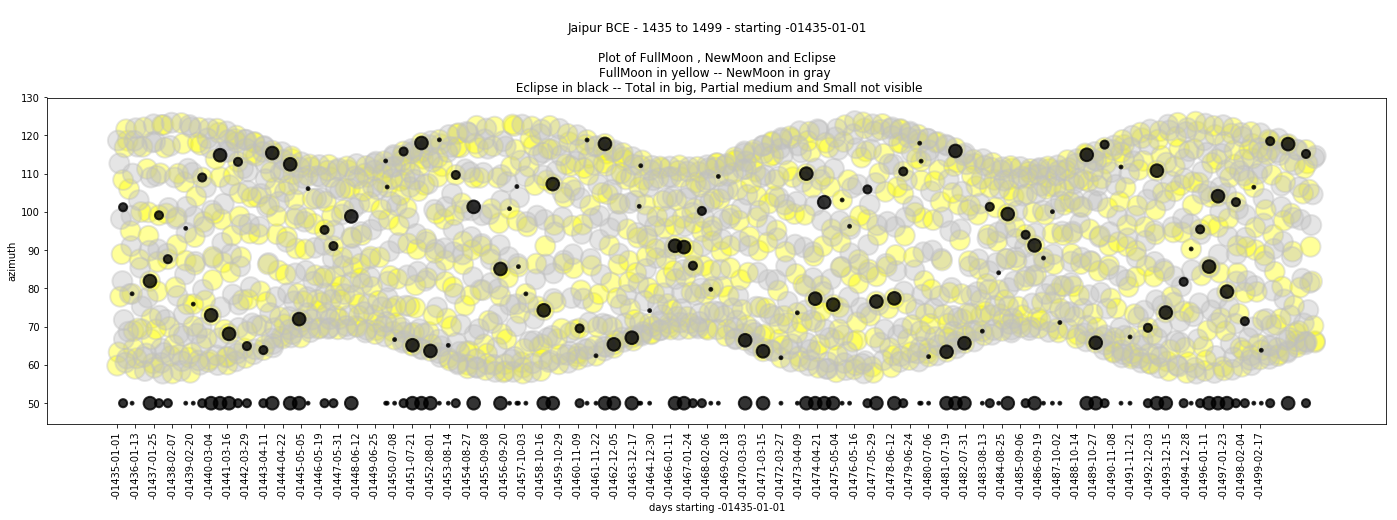

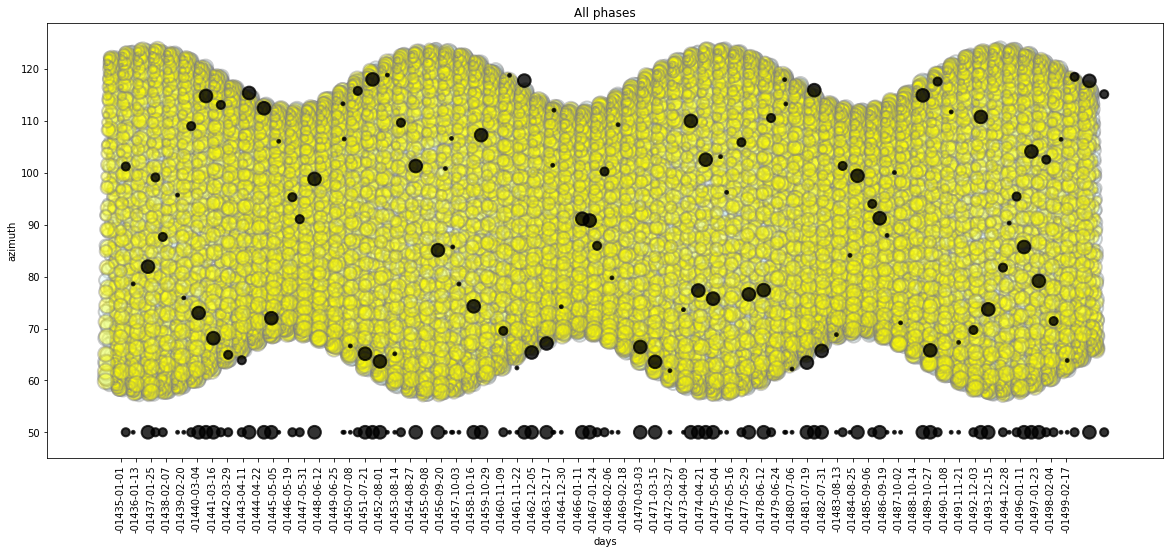

In [141]:
#do_plot(Moon_info.iloc[365*0 : 365*22, :] , 'Jaipur BCE - 1st 18year Span' )
mi = Moon_info
print ( mi.shape)
do_plot(mi , 'Jaipur BCE - 1435 to 1499' )

In [11]:
df.head()

,MoonRise,Az,Phase,Paksha,days,Fullmoon,Newmoon,Eclipse
0,-01435-01-01,62.9894,90.906,Shukla,364.0,0,0,0.0
1,-01435-01-02,60.5525,96.277,Shukla,363.0,0,0,0.0
2,-01435-01-03,58.5029,99.247,Shukla,362.0,0,0,0.0
3,-01435-01-04,58.9780,99.833,Shukla,361.0,1,0,0.0
4,-01435-01-05,62.0994,98.111,Krishna,360.0,0,0,0.0


In [148]:
xdf = df[df.Eclipse > 0]
xdf.loc[:,'Ts'] = [Time(d, format='fits').jd for d in xdf.MoonRise]#.diff()
xdf.loc[:,'Ts1'] = [Time(d, format='fits').jd for d in xdf.MoonRise]
xdf=xdf.set_index('Ts').sort_index()
xdf.Ts1 = xdf.Ts1.diff()

#Ts.drop([0], inplace=True)
xdf.drop( xdf.index[0], inplace=True)
#xdf = xdf.set_index('MoonRise')
#xdf['Ts'] = Ts

In [149]:
block_size=6
tetrads = [ False for z in range (0, xdf.shape[0])]
tetrads[-block_size:] = [ True for x in range (len(tetrads[-block_size:]))]
 
for z in range(0,xdf.shape[0]-7) :
    t = (xdf.iloc[0+z : block_size+z].Ts1 <= 180).all()
    for n in range (7):
        tetrads[z+n] = tetrads[z+n] or t

xdf.loc[:,'Tetrad']  = tetrads
xdf = xdf[tetrads]
xdf.loc[:,'Ts2'] = list(pd.Series(xdf.index).diff())

In [190]:
tdf = xdf.loc [: ,['MoonRise','Az', 'Phase', 'Eclipse', 'Ts1']]
tdf=tdf.rename(columns={'Ts1':'GapDays'})
tdf.iloc[0:10]

,MoonRise,Az,Phase,Eclipse,GapDays
Ts,,,,,
1174644.5,-01497-12-20,63.8361,99.956,0.1,176.0
1174792.5,-01496-05-16,106.4627,99.987,0.1,148.0
1174970.5,-01496-11-10,71.4305,99.265,0.5,178.0
1175146.5,-01495-05-05,102.5518,99.989,0.5,176.0
1175324.5,-01495-10-30,79.1643,99.979,1.0,178.0
1175501.5,-01494-04-25,104.1125,99.509,1.0,177.0
1175678.5,-01494-10-19,85.7093,99.942,1.0,177.0
1175855.5,-01493-04-14,95.4410,99.994,0.5,177.0
1176032.5,-01493-10-08,90.3239,99.936,0.1,177.0


In [191]:
tdf.iloc[18:27]

,MoonRise,Az,Phase,Eclipse,GapDays
Ts,,,,,
1190739.5,-01452-01-13,65.1182,99.377,0.1,148.0
1190916.5,-01452-07-08,118.8467,99.975,0.1,177.0
1191093.5,-01451-01-01,63.6561,99.951,1.0,177.0
1191270.5,-01451-06-27,118.0162,99.996,1.0,177.0
1191448.5,-01451-12-22,65.1399,99.544,1.0,178.0
1191624.5,-01450-06-16,115.7987,99.998,0.5,176.0
1191802.5,-01450-12-11,66.6306,99.970,0.1,178.0
1191949.5,-01449-05-07,106.5140,99.976,0.1,147.0
1191979.5,-01449-06-06,113.3199,99.418,0.1,30.0


In [192]:
tdf.iloc[28:28+7]

,MoonRise,Az,Phase,Eclipse,GapDays
Ts,,,,,
1194902.5,-01441-06-07,113.0991,99.988,0.5,176.0
1195080.5,-01441-12-02,68.1258,99.991,1.0,178.0
1195257.5,-01440-05-27,114.8197,99.274,1.0,177.0
1195434.5,-01440-11-20,72.9814,99.917,1.0,177.0
1195611.5,-01439-05-16,109.0026,99.978,0.5,177.0
1195788.5,-01439-11-09,75.8991,99.924,0.1,177.0
1195937.5,-01438-04-07,95.7150,99.271,0.1,149.0


In [ ]:
#xdf[xdf.delta < 180]
#xdf['delta2'] = xdf.MoonRise.astype('date')
#xdf['d2'] = pd.to_datetime(xdf.MoonRise, format="%YYYY-%mm-%d")
#xdf['delta2'] = xdf['delta'].rolling(6).mean().fillna(177)
t180 = datetime.strptime('1477-06-30', "%Y-%m-%d").date() - datetime.strptime('1477-01-01', "%Y-%m-%d").date()
xdf[xdf.delta <= t180]
1


In [ ]:
pd.to_datetime(['1677-10-31'], format="%Y-%m-%")

In [ ]:
t180 = datetime.strptime('1477-06-30', "%Y-%m-%d").date() - datetime.strptime('1477-01-01', "%Y-%m-%d").date()

In [ ]:
xdf.describe(include='all')

In [ ]:
datetime.timedelta(minutes=1)

In [126]:
x = [ d for d in range(17)]
x[-7:] = [ True for x in range (len(x[-7:]))]
x

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, True, True, True, True, True, True, True]

In [32]:
jd_0_dec_31 = 1721424.5 
print([ Time(jd_0_dec_31+1*n, format='jd').fits for n in range (-1,2)])

d1 = '01432-12-31'
d2 = '01431-01-01'

[
[ sign+d1, Time( sign+d1, format='fits').jd, 
  sign+d2, Time( sign+d2, format='fits').jd, 
  Time( sign+d1, format='fits').jd - Time( sign+d2, format='fits').jd , 
 (Time( sign+d1, format='fits') - Time( sign+d2, format='fits')).jd , 
] for sign in [ '-' , '+']
]


['+00000-12-30T00:00:00.000', '+00000-12-31T00:00:00.000', '0001-01-01T00:00:00.000']


[['-01432-12-31', 1198397.5, '-01431-01-01', 1198398.5, -1.0, -1.0],
 ['+01432-12-31', 2244451.5, '+01431-01-01', 2243721.5, 730.0, 730.0]]

In [38]:
pd.DataFrame ( {'A': [ Time( d, format='jd').fits for d in range(0,400,20)] , 'B' : range(0,400,20) })

,A,B
0,-04713-11-24T12:00:00.000,0
1,-04713-12-14T12:00:00.000,20
2,-04712-01-03T12:00:00.000,40
3,-04712-01-23T12:00:00.000,60
4,-04712-02-12T12:00:00.000,80
5,-04712-03-03T12:00:00.000,100
6,-04712-03-23T12:00:00.000,120
7,-04712-04-12T12:00:00.000,140
8,-04712-05-02T12:00:00.000,160
9,-04712-05-22T12:00:00.000,180


In [152]:
Time('-01441-06-07', format='fits')  - Time('-01442-12-13', format='fits')

<TimeDelta object: scale='tai' format='jd' value=176.0>